# Analysis of Monte Carlo simulations of mutation accumulation 

Written by [Peter McHale](http://ccbs-76.bio.uci.edu/~petermchale/) 

This Notebook illustrates the following:

This Notebook lives at [Github](https://github.com/petermchale/mutation_accumulation/tree/master/example). Follow these [easy-to-follow instructions](http://jupyter.readthedocs.io/en/latest/install.html)
to execute the Notebook using Python. Otherwise, [view this Notebook](
(http://nbviewer.jupyter.org/github/petermchale/mutation_accumulation/tree/master/example/analysis.ipynb?flush_cache=true) in read-only mode using [Jupyter Notebook Viewer](http://nbviewer.jupyter.org). 

In [1]:
import datetime
print('the current date is: ') 
print(datetime.date.today())

the current date is: 
2016-10-08


## The Protective Role of Symmetric Stem Cell Division on the Accumulation of Heritable Damage
Stem cell divisions are either asymmetric—in which one daughter cell remains a stem cell and one does not—or symmetric, in which both daughter cells adopt the same fate, either stem or non-stem. Recent studies show that in many tissues stem cell division patterns are strongly biased toward the symmetric outcome, raising the question of whether symmetry confers some benefit. 

In [this publication](http://journals.plos.org/ploscompbiol/article?id=10.1371%2Fjournal.pcbi.1003802), we showed that symmetry, via extinction of damaged stem-cell clones, reduces the lifetime risk of accumulating phenotypically silent heritable damage (mutations or aberrant epigenetic changes) in individual stem cells. We also identified the circumstances under which the protective effect of symmetry is greatest. 

## The `tumor` package
`tumor` is a Python package that contains a number of modules that permit tumor growth simulations.

In [2]:
import tumor_package
help(tumor_package)

Help on package tumor_package:

NAME
    tumor_package

FILE
    /Users/petermchale/Dropbox/PycharmProjects/tumor-master/tumor_package/__init__.py

PACKAGE CONTENTS
    animate
    energy
    ensemble
    events
    read
    self_renewal_probability
    tumor
    write




In [30]:
# To make these modules visible to the Notebook, edit the python search path.
import os
repository_directory = os.getcwd() 
package_directory = repository_directory + '/tumor_package'
print('package directory:\t' + package_directory)
import sys
print('Python searches these paths when asked to import a module:')
sys.path.append(package_directory)
for path in sys.path: 
    print(path)

package directory:	/Users/petermchale/Dropbox/PycharmProjects/tumor-master/tumor_package
Python searches these paths when asked to import a module:

/Users/petermchale/Dropbox/PycharmProjects/tumor-master
/Users/petermchale/Dropbox/PycharmProjects/tumor
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python27.zip
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7/plat-darwin
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7/plat-mac
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7/plat-mac/lib-scriptpackages
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7/lib-tk
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/pyth

## Simulating tumor growth 

In [14]:
# the initial condition and parameter values are stored in Dictionaries
from read import read_into_dict
initialCondition = read_into_dict('data/initialCondition.in')
parameterValues = read_into_dict('data/parameterValues.in')

# simulate and store the resultant time course in an animation object
from animate import animate_tumor_growth_base
fig, anim = animate_tumor_growth_base(initialCondition, parameterValues, number_of_frames=400, random_seed=2)

To embed the matplotlib animation `anim` in the notebook, I follow [Louis Tiao's blog post](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/). This requires a recent version of [Matplotlib](http://matplotlib.org), and an animation writer called [ffmpeg](https://ffmpeg.org), which you can install by first installing [Homebrew](http://brew.sh) and then typing `brew install ffmpeg` in the `Terminal`.

In [11]:
# Check matplotlib and ffmpeg
import matplotlib as mpl
print('matplotlib version:\t' + mpl.__version__ + '\t (should be at least 1.5.1)')
from matplotlib import pyplot as plt
print('animation writer:\t' + plt.rcParams['animation.writer'] + '\t (should be ffmpeg)')

matplotlib version:	1.4.3	 (should be at least 1.5.1)
animation writer:	ffmpeg	 (should be ffmpeg)


In [6]:
# Simulate and visualize the tumor using a HTML5 video tag
from IPython.display import HTML
HTML(anim.to_html5_video())

AttributeError: 'FuncAnimation' object has no attribute 'to_html5_video'

In this movie, each disc represents a tumor cell. Color indicates whether the cell is in a cycling state (green) or a quiescent state (red). Time is measured in units of a cell cycle: the average time that elapses between a cell's birth and its division. 

The movie shows the interplay between cycling (C) and quiescent (Q) cells during tumor growth. Early on, C-cells self-renew, mostly amplifying their own numbers but also occasionally differentiating to produce Q-cells. Once the number of Q-cells crosses a threshold value (inverse feedback gain; see below), a brief second phase begins during which the C-cells differentiate, rapidly reducing their numbers, increasing the numbers of Q-cells, and arresting tumor growth. Finally, in a third phase, the tumor regresses due to cell death. 

## Modeling cell division, quiescence, and feedback
Having visualized the output of the model, let us now describe it in more detail. The fate of a C-cell is modeled as a continuous-time Poisson process in which the cell either divides or becomes quiescent after an exponentially distributed random time interval. If a C-cell self-renews, its daughters are displaced in opposite directions. All this can be conveniently represented mathematically as

\begin{equation} 
C_{\vec{x}} \xrightarrow{1} \left\{ \begin{array}{ll}         
 C_{\vec{x} + \delta\vec{x}} +  C_{\vec{x} - \delta\vec{x}} & \mbox{with prob $p$}\\        
 Q_{\vec{x}}  & \mbox{with prob $1-p$} \end{array} \right.
\end{equation}
                
where $C_{\vec{x}}$ represents a C-cell located at position $\vec{x}$, the $1$ over the arrow on the left indicates the mean waiting time for something to happen to that cell, $p$ represents the self-renewal probability, and $\delta\vec{x}$ is a vector of fixed length but random direction. 

We suppose that C- and Q-cells within a neighborhood of a C-cell influence the chance that it self-renews:

\begin{equation} 
p = p_{max} W_{neg} W_{pos}
\end{equation}

where $W_{neg}$ and $W_{pos}$ are negative and positive feedback functions, respectively, of $N_C$ and $N_Q$, the number of C- and Q-cells in a neighborhood of the C-cell under consideration. Examples of feedback functions are

\begin{eqnarray} 
W_{neg} & = & \frac{1}{1 + s} \\
W_{pos} & = & \frac{s}{1 + s} 
\end{eqnarray}

where 

\begin{equation} 
s = (g_C N_C)^{n_C}  + (g_Q N_Q)^{n_Q}
\end{equation}

and the $g$'s are 'feedback gains'. Notice that feedback 'kicks in' when cell numbers become comparable to the inverse value of the corresponding feedback gain because it is then that the $W$ functions, which control the self-renewal probability $p$, cross over from 0 to 1.

To see how these behaviors are implemented look at `execute_divisionQuiescence_event`:

In [3]:
from events import execute_divisionQuiescence_event
help(execute_divisionQuiescence_event)

Help on function execute_divisionQuiescence_event in module events:

execute_divisionQuiescence_event(prng, cells, old_tumor_energy, parameterValues)
    Randomly choose between dividing a random cell versus making it quiescent.
    This function modifies the list of cells in place, 
    but updates the tumor energy using a functional programming style,
    i.e. the tumor energy is passed in, updated, 
    and then passed out using a return statement.



## Modeling physical interactions between cells
A cell physically interacts in two fundamental ways with other cells in its proximity. First, the existence of a cell precludes the possibility of another cell occupying the same position, a phenomenon called 'volume exclusion'. Second, cells tend to adhere to one another via molecules on their surfaces. Put another way, cell-cell interactions are strongly repulsive at short intercellular distances, weakly attractive at intermediate distances, and zero at long distances. One way to capture these constraints mathematically is to ascribe to each pair of cells an interaction energy $V$ that depends on their separation $r$ in the following way:

\begin{equation} 
V(r) = \left\{ \begin{array}{ll}         
 V_a \left(\frac{a}{r}\right)^n - V_c & r < a\\        
 -V_c  & a < r < b \\
 -V_c \frac{c-r}{c-b}  & b < r < c \\
 0  & c < r 
 \end{array} \right.
\end{equation}

The following code plots this function:


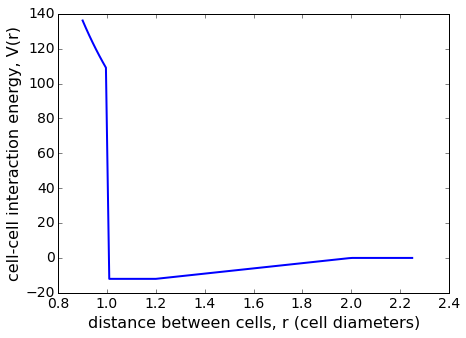

In [29]:
import numpy as np

def cell_cell_energy(rr): 
    """interaction energy between two cells located a distance rr apart"""
    
    Va = 120
    Vc = 12
    aa = 1
    bb = 1.2
    cc = 2
    nn = 2
    
    if rr < aa: 
        return Va * np.power(aa/rr, nn) - float(Vc)
    elif rr < bb: 
        return -float(Vc)
    elif rr < cc: 
        return -float(Vc) * (cc - rr)/(cc - bb)
    else: 
        return 0.0

%matplotlib inline

fontsize = 16
fontsize_tick = 14

fig = plt.figure(figsize=(7,5), facecolor='w')
ax = fig.add_subplot(111)
rr = np.linspace(0.9, 2.25, 100)  
ax.plot(rr, np.vectorize(cell_cell_energy)(rr), linewidth=2)
ax.set_xlabel('distance between cells, r (cell diameters)', fontsize=fontsize)
ax.set_ylabel('cell-cell interaction energy, V(r)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)

You can see that there is a huge energy penalty at $r<1$ reflecting the tendency of cells closer than one cell diameter to repel one another. In general, cells will tend to move so as to lower their interaction energy, which, for this energy function, corresponds to intercellular distances between 1 and 1.2 cell diameters. 

## Modeling tissue relaxation
Cell growth, division and death are slow processes that induce intercellular forces because of changes in cell size and number. The tissue responds by re-arranging its cells in such a way as to remove these forces, a process termed 'relaxation'. It occurs on a faster timescale than cell growth, division and death, probabilistically favoring cell displacements that lower the tissue energy. 

Mathematically speaking, a cell $Z$ is chosen at random at a rate $\nu\gg 1$ (recall that $1$ is the rate at which cells divide) and a random displacement $\delta \vec{x}$ proposed:

\begin{equation} 
Z_{\vec{x}} \xrightarrow{\nu} Z_{\vec{x} + \delta \vec{x}}
\end{equation} 

where $\delta \vec{x}$ is drawn from a circular Gaussian distribution. Associated with the proposed move is an energy change $\Delta E = E_{new} - E_{old}$, where 

\begin{equation} 
E  = \sum_{i < j} V (|\vec{x}_i - \vec{x}_j|)
\end{equation} 

is the tumor energy. We implement the bias towards more energetically favorable cell configurations via the Metropolis algorithm in which we always accept the proposed cell displacement when it lowers the energy and accept it with probability $e^{-\Delta E}$ when it raises the energy (by a positive amount $\Delta E$). 

A note on performance. The time needed to compute the tumor energy $E$ by summing over all cell pairs scales quadratically with tumor size. Much more efficient is to update only the cell-cell interactions energies that change after each event (division, death, relaxation) producing an algorithm that scales linearly with tumor size. `tumor` implements the faster linear algorithm.

## Statistical analysis of simulated tumor-growth data
Generate an ensemble of tumor-growth time courses  by either running 

```python
from ensemble import generate_tumor_growth_trajectories_base
generate_tumor_growth_trajectories_base(initialCondition, parameterValues, number_realizations=100, random_seed=2, output_directory_name='data/')
```

in this Notebook; or by running 

```unix
cd data 
python ../tumor_package/ensemble.py
```

in `Terminal`. Generating a large number of realizations of tumor growth takes a while. To speed up the execution of this Notebook, I will therefore use pre-existing data for long- and short-range negative feedback. Let's now read in these data and visually compare the simulated tumor-growth time courses.

In [33]:
# Read in data 

class Data(object): 
    """Container for simulation data"""
    
    def __init__(self, time_points, number_C_cells, number_Q_cells): 
    
        self.time_points = time_points
        self.number_C_cells = number_C_cells
        self.number_Q_cells = number_Q_cells
        self.total_number_cells = self.number_C_cells + self.number_Q_cells

def create_data_object_from_file(data_file_name):
    
    with np.load(data_file_name) as data_set:
        time_points = data_set['time_points']
        number_C_cells = data_set['number_C_cells']
        number_Q_cells = data_set['number_Q_cells']
    
    return Data(time_points, number_C_cells, number_Q_cells)

data_short = create_data_object_from_file('data/short_range_negative_feedback/tumor_time_courses.npz')
data_long = create_data_object_from_file('data/long_range_negative_feedback/tumor_time_courses.npz')

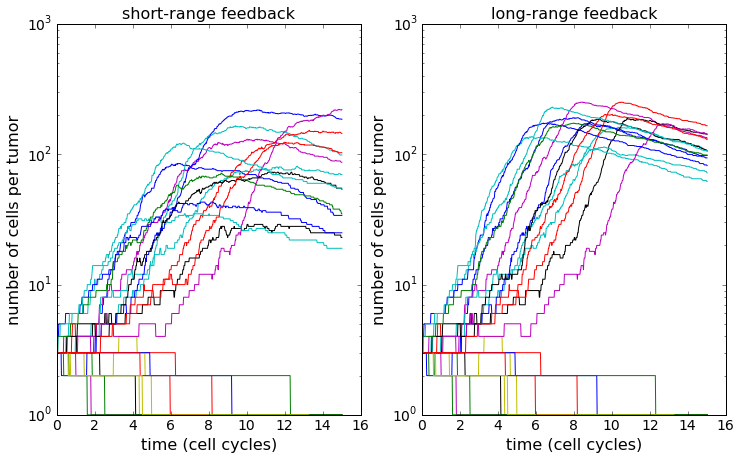

In [17]:
# Visually compare time courses for short- and long-range negative feedback

fig = plt.figure(figsize=(12, 7), facecolor='w')

def plot_time_courses(data, axis_number, title):

    number_subplot_rows, number_subplot_columns = 1, 2
    ax = fig.add_subplot(number_subplot_rows, number_subplot_columns, axis_number)
    ax.plot(data.time_points.T, data.total_number_cells.T, linewidth=1)
    ax.set_xlabel('time (cell cycles)', fontsize=fontsize)
    ax.set_ylabel('number of cells per tumor', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)
    ax.set_yscale('log')
    
def thin(data, step): 
    """down-sample time-course data"""
    
    def thin_base(arr):
        return arr[1::step, :]
    
    return Data(thin_base(data.time_points), thin_base(data.number_C_cells), thin_base(data.number_Q_cells))
    
step = 4
plot_time_courses(thin(data_short, step), axis_number=1, title='short-range feedback')
plot_time_courses(thin(data_long, step), axis_number=2, title='long-range feedback')

A number of trends are evident in these plots, in which each color represents a single realization of a growing tumor. 

First, negative feedback can arrest tumor growth even when the spatial range of feedback is smaller than the maximum tumor size (left panel). Fundamentally, this is possible because controlling the growth of the tumor early is more important than doing so late; in other words, errors have less impact when corrected early rather than late. 

Second, increasing the spatial range of the negative feedback makes the large-number part of the trajectories more deterministic (right panel). In particular, you can clearly see that many trajectories possess an early exponential growth phase (due to the tumors being mainly composed of self-replicating C-cells) and a late exponential regression phase (during which tumors are composed mainly of Q-cells that are killed off at a constant rate per cell). 

Third, some tumors survive the initial fluctuations in tumor size to grow deterministically (right panel). For these tumors, most of their variability is explained by the randomness in the time at which they 'take off', e.g. the time at which there are at least 10 cells. Other tumors are not so 'lucky': the initial fluctuations prevent them from ever entering the deterministic growth phase.  These 'unlucky' tumors &mdash; doomed to regression from their inception &mdash; are not rare. In fact, as many as half of the tumors are destined to 'extinguish', as the following histogram shows...

number of samples = 100


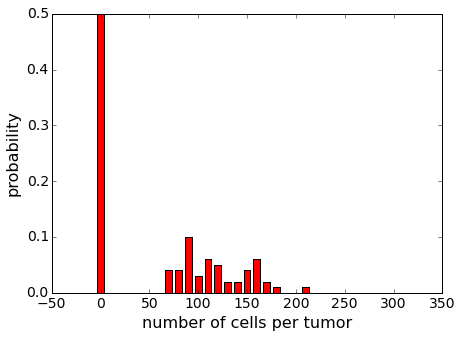

In [18]:
# plot the distribution of the number of cells per tumor at a single time point

def plot_distribution(data, bin_width=10, time_at_which_to_plot_histogram=14):

    index_at_which_to_plot_histogram = (np.abs(data.time_points[0, :] - time_at_which_to_plot_histogram)).argmin()
    total_number_cells_at_time_point = data.total_number_cells[:, index_at_which_to_plot_histogram]

    fig = plt.figure(figsize=(7, 5), facecolor='w')
    ax = fig.add_subplot(111)
    x_max = max(data.total_number_cells.flatten()) + 2*bin_width    
    bin_edges = np.arange(-0.5*bin_width, x_max, bin_width)
    counts = np.histogram(total_number_cells_at_time_point, bin_edges)[0]
    counts = np.array(counts)
    probabilities = counts/float(sum(counts))
    rectangle_width = 0.7 * bin_width
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    rectangle_left_edges = bin_centers - 0.5*rectangle_width
    ax.bar(left=rectangle_left_edges, height=probabilities, width=rectangle_width, color='red')
    ax.set_xlabel('number of cells per tumor', fontsize=fontsize)
    ax.set_ylabel('probability', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)
    print('number of samples = ' + str(len(total_number_cells_at_time_point)))
    
plot_distribution(data_long)

The following interactive visualization was inspired by [this mpld3 example](http://mpld3.github.io/examples/custom_plugin.html). If your Python distribution doesn't already have `mpld3`, you'll need to install it, e.g., by executing
``` 
pip install mpld3
``` 
in `Terminal`. `mpld3` allows the user to combine [Matplotlib](http://matplotlib.org/), the popular Python-based graphing library, and [D3](https://d3js.org), the popular Javascript library for creating interactive data visualizations for the web.  

Having set up the interactive data visualization tools, we use them to produce an interactive scatter plot:

Each point in the scatter plot corresponds to a single growth trajectory. The size of the points in the scatter plot (left) reflect the maximum number of C-cells reached during the course of the simulation. When that number is small, trajectories are highly variable whereas when that number is large trajectories are more uniform, as can be seen by hovering over the points in the scatter plot and viewing the associated time courses on the right. (Use the toolbar buttons at the bottom-left of the plot to enable zooming and panning, and to reset the view.) 

Notice that small points in the scatter plot lie away from the diagonal whereas large points lie close to it. This means that noisy trajectories exhibit a poorer correlation between the time courses of C- and Q-cells than do deterministic ones. Could averaging out noise, making all trajectories more deterministic, improve the correlation? One way to average out noise is spatially, by extending the spatial range of negative feedback. When we do this and re-examine the scatter plot (shown below), we do indeed observe a tighter correlation between C- and Q-cell numbers. 

Notice that the cell numbers are now much larger than they were for short-range feedback (e.g. compare size of points in the two scatter plots). That is to say, extending the range of influence of negative feedback actually makes tumors larger, not smaller as one might have naively expected. Results such as these emphasize the non-intuitive role that space can play in tumor growth.

## Summary

Our simulations have led to some non-intuitive results concerning the lineage-based integral-feedback hypothesis of tumor growth control:
- tumors can arrest their growth at a size larger than the spatial range of negative feedback
- extending the spatial range of influence of negative feedback can make tumors larger (not smaller)